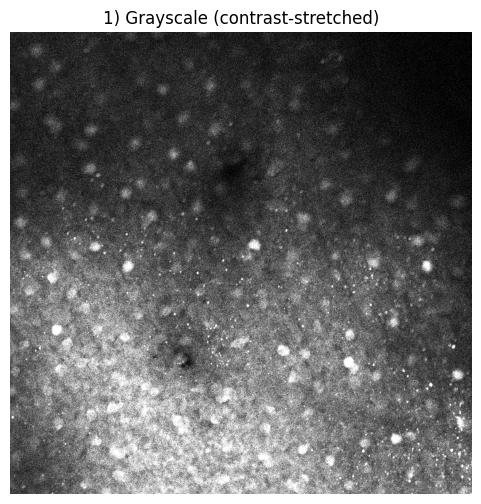

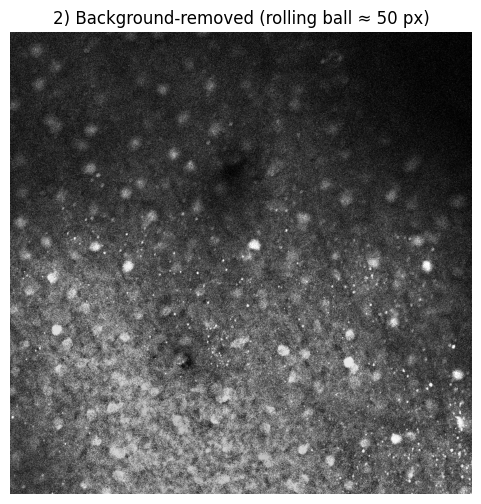

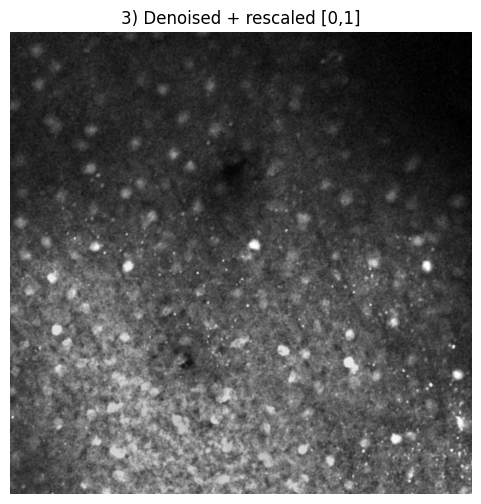

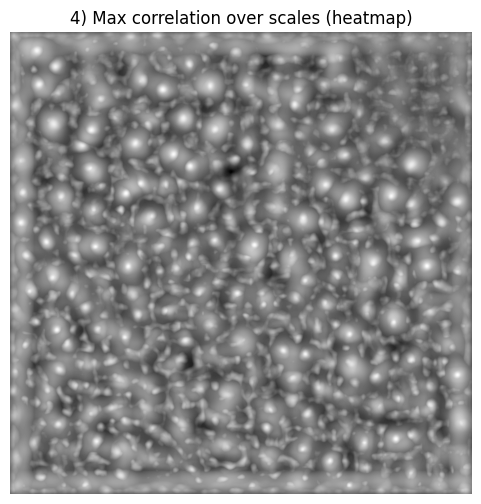

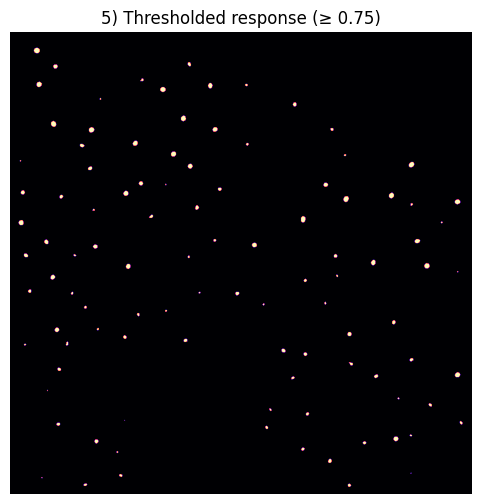

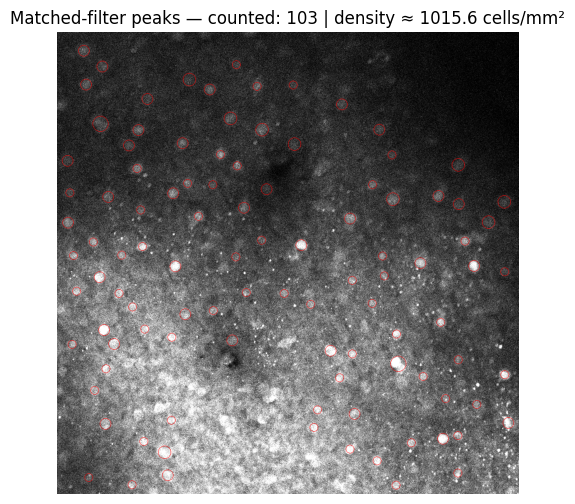

In [1]:
import numpy as np, matplotlib.pyplot as plt
from math import pi, sqrt
from skimage import io, color, util, exposure, filters, morphology
from skimage.feature import match_template, peak_local_max
from skimage.draw import circle_perimeter
import scipy.ndimage as ndi

# ========= knobs =========
image_path     = r"./raw_GFP.png"
pixel_size_um  = 0.311

# expected cell diameter band (µm)
d_min_um, d_max_um = 6, 20.0   #change if needed
n_scales           = 10         # number of template sizes in the band
corr_threshold     = 0.75       # 0..1; lower -> more detections
min_separation_um  = 2.0        # suppress peaks closer than this (non-maxima), seprates connected cells

# preprocessing
rb_radius   = 50               # rolling-ball for background
gauss_sigma = 0.8              # light blur
# =========================

def show(img, title, cmap="gray"):
    plt.figure(figsize=(6,6)); plt.imshow(img, cmap=cmap); plt.title(title); plt.axis("off"); plt.show()

def rolling_ball(gray, radius=50):
    try:
        from skimage.restoration import subtract_background_rolling_ball
        return subtract_background_rolling_ball(gray, radius=radius)
    except Exception:
        se = morphology.disk(radius)
        try:    return morphology.white_tophat(gray, footprint=se)
        except TypeError:
                return morphology.white_tophat(gray, selem=se)

def make_soft_disk_template(r_px):
    """soft circular template (disk blurred with Gaussian)"""
    sz = int(2*np.ceil(r_px*1.6)+1)  # a bit larger than diameter
    yy, xx = np.mgrid[-sz//2:sz//2+1, -sz//2:sz//2+1]
    rr = np.sqrt(xx**2 + yy**2)
    disk = (rr <= r_px).astype(float)
    tmpl = filters.gaussian(disk, sigma=max(1.0, 0.25*r_px), preserve_range=True)
    # match_template does its own normalization, so we can return as-is
    return tmpl

# 1) grayscale + stretch
img = io.imread(image_path)
if img.ndim == 3 and img.shape[-1] == 4: img = color.rgba2rgb(img)
if img.ndim == 3: img = color.rgb2gray(img)
gray = util.img_as_float(img)
p2,p98 = np.percentile(gray,(2,98))
gray = exposure.rescale_intensity(gray, in_range=(p2,p98))
show(gray, "1) Grayscale (contrast-stretched)")

# 2) background removal
bg = rolling_ball(gray, radius=rb_radius)
show(bg, f"2) Background-removed (rolling ball ≈ {rb_radius} px)")

# 3) denoise + rescale to [0,1]
den = filters.gaussian(filters.median(bg, morphology.disk(2)), sigma=gauss_sigma, preserve_range=True)
den01 = exposure.rescale_intensity(den, in_range='image', out_range=(0,1))
show(den01, "3) Denoised + rescaled [0,1]")

# 4) template bank (multi-scale) correlation
diam_um = np.linspace(d_min_um, d_max_um, n_scales)
r_px_list = (diam_um/2.0) / pixel_size_um
responses = []
for r_px in r_px_list:
    tmpl = make_soft_disk_template(r_px)
    resp = match_template(den01, tmpl, pad_input=True)  # normalized correlation [-1, 1]
    responses.append(resp)

resp_stack = np.stack(responses, axis=-1)
resp_max   = resp_stack.max(axis=-1)
scale_idx  = resp_stack.argmax(axis=-1)  # index of best size per pixel

show(resp_max, "4) Max correlation over scales (heatmap)")

# 5) peak detection on the correlation map
min_dist_px = max(2, int(round((min_separation_um/pixel_size_um))))
peaks = peak_local_max(
    resp_max, threshold_abs=corr_threshold, min_distance=min_dist_px, exclude_border=False
)
show((resp_max >= corr_threshold).astype(float), f"5) Thresholded response (≥ {corr_threshold:.2f})", cmap="magma")

# 6) build detections (center + radius from chosen scale) and overlay
overlay = np.dstack([gray, gray, gray]).copy()
count = 0
for (y, x) in peaks:
    r_px = r_px_list[ scale_idx[y, x] ]
    r_draw = int(max(2, min(r_px, (d_max_um/pixel_size_um)/2.0)))
    rr, cc = circle_perimeter(int(y), int(x), r_draw, shape=overlay.shape)
    overlay[rr, cc, 0] = 1.0; overlay[rr, cc, 1] = 0.0; overlay[rr, cc, 2] = 0.0
    count += 1

# 7) density
h, w = gray.shape
area_mm2 = (pixel_size_um**2) * h * w / 1e6
density = count/area_mm2 if area_mm2>0 else np.nan

plt.figure(figsize=(6,6)); plt.imshow(overlay)
plt.title(f"Matched-filter peaks — counted: {count} | density ≈ {density:.1f} cells/mm²")
plt.axis("off"); plt.show()


In [79]:
# ---- save diameters (µm) + centers (px & µm) beside the image file ----
import os

lines = ["id,y_px,x_px,y_um,x_um,diam_um,corr"]
for i, (y, x) in enumerate(peaks, start=1):
    r_px = float(r_px_list[int(scale_idx[y, x])])   # matched radius (px)
    diam_um = 2.0 * r_px * pixel_size_um
    corr = float(resp_max[y, x])                    # correlation score at peak

    lines.append(
        f"{i},{y:.3f},{x:.3f},{y*pixel_size_um:.4f},{x*pixel_size_um:.4f},{diam_um:.4f},{corr:.4f}"
    )

root, _ = os.path.splitext(image_path)  # removes .png/.tif/.jpg/etc.
out_csv = root + "_data.csv"            # e.g., S4_CT_GCL_GFP_data.csv

with open(out_csv, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print(f"Saved {len(peaks)} cells to: {out_csv}")
